# Feature Extraction Layer

## **Description:**

- Create a simpe feature extraction step
- No extensive modeling or feature extraction is required, we need just to ensure our modeling step is trustworthy:
    - We don't have any target leakage

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from scripts.feature_extr import FeatureExtractionLayer # feature_extr.py module
from scripts.etl import transform_df_types

import warnings
warnings.filterwarnings('ignore')

## Load and transform train, aggregated train and test datasets

In [2]:
train_df = pd.read_csv('../data/merged_train.csv')
aggregated_train_df = pd.read_csv('../data/merged_train_aggregated.csv')
test_df = pd.read_csv('../data/merged_test.csv')

aggregated_train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name
0,0,2,27,1,2499.0,0,0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега"""
1,0,2,33,1,499.0,0,0,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега"""
2,0,2,317,1,299.0,0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,Книги - Аудиокниги 1С,"Адыгея ТЦ ""Мега"""


In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])

int_columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'month', 'year', 'item_category_id']
float_columns = ['item_price']
object_columns = ['item_name', 'item_category_name', 'shop_name']

train_df = transform_df_types(train_df, int_columns, float_columns, object_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935848 entries, 0 to 2935847
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        int32         
 6   month               int32         
 7   year                int32         
 8   item_name           category      
 9   item_category_id    int32         
 10  item_category_name  category      
 11  shop_name           category      
dtypes: category(3), datetime64[ns](1), float32(1), int32(7)
memory usage: 123.9 MB


In [4]:
int_columns = ['date_block_num', 'shop_id', 'item_id', 'month', 'year', 'item_category_id']
float_columns = ['item_price', 'item_cnt_month']
object_columns = ['item_name', 'item_category_name', 'shop_name']

aggregated_train_df = transform_df_types(aggregated_train_df, int_columns, float_columns, object_columns)
aggregated_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   date_block_num      1608724 non-null  int32   
 1   shop_id             1608724 non-null  int32   
 2   item_id             1608724 non-null  int32   
 3   item_cnt_month      1608724 non-null  float32 
 4   item_price          1608724 non-null  float32 
 5   month               1608724 non-null  int32   
 6   year                1608724 non-null  int32   
 7   item_name           1608724 non-null  category
 8   item_category_id    1608724 non-null  int32   
 9   item_category_name  1608724 non-null  category
 10  shop_name           1608724 non-null  category
dtypes: category(3), float32(2), int32(6)
memory usage: 55.9 MB


In [5]:
int_columns = ['ID', 'shop_id', 'item_id', 'item_category_id']
object_columns = ['item_name', 'item_category_name', 'shop_name']

test_df = transform_df_types(test_df, int_columns, object_columns=object_columns)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ID                  214200 non-null  int32   
 1   shop_id             214200 non-null  int32   
 2   item_id             214200 non-null  int32   
 3   item_name           214200 non-null  category
 4   item_category_id    214200 non-null  int32   
 5   item_category_name  214200 non-null  category
 6   shop_name           214200 non-null  category
dtypes: category(3), int32(4)
memory usage: 4.3 MB


## Add records with **item_cnt_month = 0** (optional for kaggle submissions)

Train dataset fairly doesn't contain information about "selling nothing", but in the same time some of the items in the test set can easily be not sold at all. 
That's why I add these zeroes to make models predict zero sales as well

In [6]:
aggregated_train_df = FeatureExtractionLayer.add_zero_records(aggregated_train_df, num_new_records=100000)

In [7]:
zero_proportion = len(aggregated_train_df[aggregated_train_df['item_cnt_month'] == 0]) / len(aggregated_train_df)
print(f"Proportion of zero records: {round(zero_proportion * 100, 2)} %")

Proportion of zero records: 6.0 %


# Feature extraction process

### I will use custom **FeatureExtractionLayer** class to create some new features for both train and test datasets. This can be done by simply running **train_transform()** and **test_transform()** methods of this class (they will be tested at the end of the notebook). Now I will perform all the transformations step by step to make everything a little clearer

In [8]:
second_train_df = train_df.copy()
second_aggregated_train_df = aggregated_train_df.copy()
second_test_df = test_df.copy()

## Add **"months since the last sale for each item, shop and date_block_num"** feature

In [9]:
aggregated_train_df = FeatureExtractionLayer.train_add_months_since_last_sale(aggregated_train_df, load_precalculated=False)
aggregated_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708724 entries, 0 to 1708723
Data columns (total 12 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   date_block_num          int32   
 1   shop_id                 int32   
 2   item_id                 int32   
 3   item_cnt_month          float32 
 4   item_price              float32 
 5   month                   int32   
 6   year                    int32   
 7   item_name               category
 8   item_category_id        int32   
 9   item_category_name      category
 10  shop_name               category
 11  months_since_last_sale  int32   
dtypes: category(3), float32(2), int32(7)
memory usage: 65.9 MB


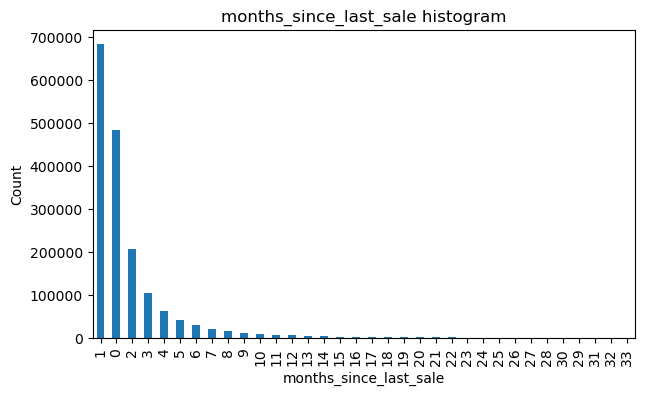

In [10]:
aggregated_train_df['months_since_last_sale'].value_counts().plot(kind='bar', figsize=(7, 4), ylabel='Count', xlabel='months_since_last_sale', title='months_since_last_sale histogram');

Looks like the **months_since_last_sale** feature was calculated properly

### Add **months_since_last_sale** feature to the test dataframe

In [11]:
test_df = FeatureExtractionLayer.test_add_months_since_last_sale(aggregated_train_df, test_df, load_precalculated=False)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      214200 non-null  int32   
 1   shop_id                 214200 non-null  int32   
 2   item_id                 214200 non-null  int32   
 3   item_name               214200 non-null  category
 4   item_category_id        214200 non-null  int32   
 5   item_category_name      214200 non-null  category
 6   shop_name               214200 non-null  category
 7   months_since_last_sale  214200 non-null  int32   
dtypes: category(3), int32(5)
memory usage: 5.1 MB


## Add **revenue** lag features

### Calculate revenue

In [12]:
train_df['revenue'] = train_df['item_price'] * train_df['item_cnt_day']
train_aggregated = train_df.groupby(['date_block_num', 'shop_id']).agg({'revenue': 'sum'}).reset_index()

aggregated_train_df = aggregated_train_df.merge(train_aggregated, on=['date_block_num', 'shop_id'], how='left')

In [13]:
aggregated_train_df['revenue'].fillna(0, inplace=True)
aggregated_train_df.isna().sum().sum()

0

### Calculate **historical mean** revenue information

For each pair *(month, shop)* get average revenue for that shop along all previous months

In [14]:
# 1. shop
aggregated_train_df = FeatureExtractionLayer.calculate_historical_mean(aggregated_train_df, 'revenue', ['shop_id'])
aggregated_train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue,revenue_mean_on_shop_id
0,0,2,27,1.0,2499.0,0,0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега""",0,1085064.75,NaN
1,0,2,33,1.0,499.0,0,0,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега""",0,1085064.75,NaN
2,0,2,317,1.0,299.0,0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,Книги - Аудиокниги 1С,"Адыгея ТЦ ""Мега""",0,1085064.75,NaN


In [15]:
aggregated_train_df['revenue_mean_on_shop_id'].isna().sum()

66077

In [16]:
aggregated_train_df['revenue_mean_on_shop_id'].fillna(0, inplace=True)

### Do this for the **test** dataframe as well

In [17]:
test_df = FeatureExtractionLayer.test_calculate_historical_mean(test_df, aggregated_train_df, 'revenue', ['shop_id'])

In [18]:
print(test_df.isna().sum().sum())
test_df.head(3)

0


,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625


### Add revenue information for each **date_block_num** and **shop_id** for lags = [1, 2, 3]

In [19]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_train_df, 'revenue', on_columns=['shop_id', 'date_block_num'], operation='mean', lags=[1, 2, 3])

In [20]:
aggregated_lagged[aggregated_lagged['date_block_num'] == 20].head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3
9726,20,2,32,2.0,149.0,8,1,1+1,40,Кино - DVD,"Адыгея ТЦ ""Мега""",2,1473540.0,1.194009e+06,1194669.0,1102918.5,1263924.0
9727,20,2,33,1.0,199.0,8,1,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега""",8,1473540.0,1.194009e+06,1194669.0,1102918.5,1263924.0
9728,20,2,450,0.0,399.0,8,1,Sample Item,26,Sample Category,Sample Shop,0,1473540.0,1.194009e+06,1194669.0,1102918.5,1263924.0


### Do this for the **test** dataframe as well

In [21]:
test_lagged = FeatureExtractionLayer.test_add_lag_features(test_df, aggregated_train_df, col='revenue', on_columns=['shop_id'], lags=[1, 2, 3])

In [22]:
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,1171450.0,1160948.5
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,1171450.0,1160948.5
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,1171450.0,1160948.5


## Clip **item_cnt_month** feature into [0, 20] range (optional for kaggle)

It is said in the kaggle competition overview, that *true target values of the test dataset are clipped into [0, 20] range*. So clipping will help to make the train target similar to the test predictions

In [23]:
print(len(aggregated_lagged[aggregated_lagged['item_cnt_month'] < 0]))
print(len(aggregated_lagged[aggregated_lagged['item_cnt_month'] > 20]))

890
11463


When not predicting for kaggle, it's reasonable to leave values that don't get into [0, 20] range. Train data contains a few examples of returning items during the next months (which results in negative item_cnt_month values) as well as examples of selling more than 20 items in a particular shop.

I've added the "clip_target" parameter to the train/test transform methods in case this affects the predictions.

In [24]:
aggregated_lagged['item_cnt_month'] = aggregated_lagged['item_cnt_month'].clip(0, 20)

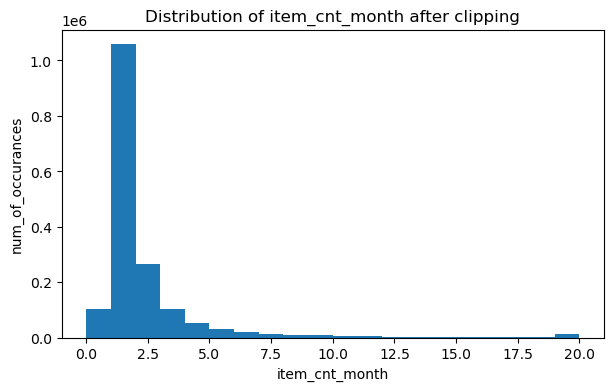

In [25]:
aggregated_lagged['item_cnt_month'].plot(kind='hist', bins=20, xlabel='item_cnt_month', ylabel='num_of_occurances', title='Distribution of item_cnt_month after clipping', figsize=(7, 4));

In [26]:
print(f"Rows with item_cnt_month == 20: {round(len(aggregated_lagged[aggregated_lagged['item_cnt_month'] == 20]) / len(aggregated_lagged) * 100, 3)} %")

Rows with item_cnt_month == 20: 0.731 %


## Calculate **historical mean** for item_cnt_month information

For each pair *(month, item)* get average count of sales along all previous months. NaNs are firstly replaced with the historical mean for a corresponding category

In [27]:
aggregated_lagged = FeatureExtractionLayer.calculate_historical_mean(aggregated_lagged, 'item_cnt_month', on_columns=['item_id'])
aggregated_lagged.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3,item_cnt_month_mean_on_item_id
0,14,6,0,0.0,399.0,2,1,Sample Item,25,Sample Category,Sample Shop,0,2962045.0,3.138444e+06,2951829.75,3130598.75,5769902.0,NaN
1,20,54,0,1.0,58.0,8,1,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,Кино - DVD,"Химки ТЦ ""Мега""",0,4839335.0,5.038682e+06,4611502.00,3584843.75,5087624.0,0.0
2,24,14,0,0.0,399.0,0,2,Sample Item,49,Sample Category,Sample Shop,0,1385912.0,1.432682e+06,2421322.75,2465137.00,1304777.0,0.5


In [28]:
aggregated_lagged.isna().sum().sum()

129858

In [29]:
aggregated_lagged = FeatureExtractionLayer.calculate_historical_mean(aggregated_lagged, 'item_cnt_month', on_columns=['item_category_id'])
aggregated_lagged.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3,item_cnt_month_mean_on_item_id,item_cnt_month_mean_on_item_category_id
0,0,25,16257,1.0,148.0,0,0,Наушники RITMIX RH-124 Black,0,PC - Гарнитуры/Наушники,"Москва ТРК ""Атриум""",0,5376478.0,0.000000e+00,0.000,0.0,0.000,NaN,NaN
1,1,57,16255,1.0,93.0,1,0,Наушники PHILIPS SBC HC8680,0,PC - Гарнитуры/Наушники,"Якутск Орджоникидзе, 56",0,3670958.0,2.966412e+06,2966412.000,0.0,0.000,NaN,1.0
2,3,38,16256,1.0,22.4,3,0,Наушники RITMIX RH-120,0,PC - Гарнитуры/Наушники,"Омск ТЦ ""Мега""",0,1256294.5,1.764068e+06,1918332.875,1581008.0,1792861.875,NaN,1.0


In [30]:
aggregated_lagged['item_cnt_month_mean_on_item_id'].fillna(aggregated_lagged['item_cnt_month_mean_on_item_category_id'], inplace=True)
aggregated_lagged['item_cnt_month_mean_on_item_id'].isna().sum().sum()

64133

In [31]:
aggregated_lagged.drop('item_cnt_month_mean_on_item_category_id', axis=1, inplace=True)
aggregated_lagged['item_cnt_month_mean_on_item_id'].fillna(0, inplace=True)

### Do this for the **test** dataframe as well

In [32]:
test_lagged = FeatureExtractionLayer.test_calculate_historical_mean(test_lagged, aggregated_lagged, 'item_cnt_month', on_columns=['item_id'])
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3,item_cnt_month_mean_on_item_id
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,1171450.0,1160948.5,2.851685
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,1171450.0,1160948.5,NaN
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,1171450.0,1160948.5,2.573604


In [33]:
test_lagged = FeatureExtractionLayer.test_calculate_historical_mean(test_lagged, aggregated_lagged, 'item_cnt_month', on_columns=['item_category_id'])
test_lagged['item_cnt_month_mean_on_item_category_id'].isna().sum().sum()

0

In [34]:
test_lagged['item_cnt_month_mean_on_item_id'].fillna(test_lagged['item_cnt_month_mean_on_item_category_id'], inplace=True)
test_lagged.drop('item_cnt_month_mean_on_item_category_id', axis=1, inplace=True)

## Add **target (item_cnt_month)** lag features for lags = [1, 2, 3]

In [35]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_lagged, 'item_cnt_month', on_columns=['item_id', 'shop_id', 'date_block_num'], lags=[1, 2, 3])

In [36]:
aggregated_lagged[aggregated_lagged['date_block_num'] == 15].tail(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,months_since_last_sale,revenue,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3,item_cnt_month_mean_on_item_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
1706387,15,45,22092,3.0,109.0,3,1,Элемент питания DURACELL TURBO LR6 2*BL,83,Элементы питания,...,1,909003.0,1.414928e+06,1465806.0,1546322.0,1526386.0,4.866610,5.0,2.0,2.0
1706388,15,59,22092,1.0,109.0,3,1,Элемент питания DURACELL TURBO LR6 2*BL,83,Элементы питания,...,2,1003400.0,1.447219e+06,1489123.0,1675142.0,1157716.5,4.866610,0.0,1.0,5.0
1706389,15,49,22114,0.0,399.0,3,1,Sample Item,83,Sample Category,...,0,652322.0,7.017755e+05,804475.0,748218.0,874329.0,1.108761,0.0,0.0,0.0


### Do this for the **test** dataframe as well

In [37]:
test_lagged = FeatureExtractionLayer.test_add_lag_features(test_lagged, aggregated_lagged, col='item_cnt_month', on_columns=['item_id', 'shop_id'], lags=[1, 2, 3])

In [38]:
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3,item_cnt_month_mean_on_item_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,1171450.0,1160948.5,2.851685,0.0,1.0,3.0
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,1171450.0,1160948.5,1.395362,0.0,0.0,0.0
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,1171450.0,1160948.5,2.573604,1.0,3.0,1.0


## Add average **target (item_cnt_month)** lag features by month for lags = [1, 2, 3]

In [39]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_lagged, 'item_cnt_month', add_name='_date_', on_columns=['date_block_num'], lags=[1, 2, 3])

In [40]:
test_lagged['date_block_num'] = 34
test_lagged = FeatureExtractionLayer.test_add_lag_features_for_month(test_lagged, aggregated_lagged, col='item_cnt_month', add_name='_date_', on_columns=['date_block_num'], lags=[1, 2, 3])
test_lagged.drop('date_block_num', axis=1, inplace=True)
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,revenue_lag_2,revenue_lag_3,item_cnt_month_mean_on_item_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_date__lag_1,item_cnt_month_date__lag_2,item_cnt_month_date__lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,1171450.0,1160948.5,2.851685,0.0,1.0,3.0,1.953094,1.68673,1.626151
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,1171450.0,1160948.5,1.395362,0.0,0.0,0.0,1.953094,1.68673,1.626151
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,1171450.0,1160948.5,2.573604,1.0,3.0,1.0,1.953094,1.68673,1.626151


## Add average **target (item_cnt_month)** lag features by category for lags = [1, 2, 3]

In [41]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_lagged, 'item_cnt_month', add_name='_cat_', on_columns=['item_category_id', 'date_block_num'], lags=[1, 2, 3])
test_lagged = FeatureExtractionLayer.test_add_lag_features(test_lagged, aggregated_lagged, col='item_cnt_month', add_name='_cat_', on_columns=['item_category_id'], lags=[1, 2, 3])
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,...,item_cnt_month_mean_on_item_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_date__lag_1,item_cnt_month_date__lag_2,item_cnt_month_date__lag_3,item_cnt_month_cat__lag_1,item_cnt_month_cat__lag_2,item_cnt_month_cat__lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,...,2.851685,0.0,1.0,3.0,1.953094,1.68673,1.626151,1.647497,2.161055,2.294638
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,...,1.395362,0.0,0.0,0.0,1.953094,1.68673,1.626151,1.349535,1.232640,1.269661
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,...,2.573604,1.0,3.0,1.0,1.953094,1.68673,1.626151,1.647497,2.161055,2.294638


## Add average **target (item_cnt_month)** lag features by item for lags = [1, 2, 3]

In [42]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_lagged, 'item_cnt_month', add_name='_item_', on_columns=['date_block_num', 'item_id'], lags=[1, 2, 3])
test_lagged = FeatureExtractionLayer.test_add_lag_features(test_lagged, aggregated_lagged, col='item_cnt_month', add_name='_item_', on_columns=['item_id'], lags=[1, 2, 3])
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,...,item_cnt_month_lag_3,item_cnt_month_date__lag_1,item_cnt_month_date__lag_2,item_cnt_month_date__lag_3,item_cnt_month_cat__lag_1,item_cnt_month_cat__lag_2,item_cnt_month_cat__lag_3,item_cnt_month_item__lag_1,item_cnt_month_item__lag_2,item_cnt_month_item__lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,...,3.0,1.953094,1.68673,1.626151,1.647497,2.161055,2.294638,1.470588,3.724138,3.305556
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,...,0.0,1.953094,1.68673,1.626151,1.349535,1.232640,1.269661,0.000000,0.000000,0.000000
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,...,1.0,1.953094,1.68673,1.626151,1.647497,2.161055,2.294638,1.555556,2.666667,3.846154


## Add average **target (item_cnt_month)** lag features by category and shop for lags = [1, 2, 3]

In [43]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_lagged, 'item_cnt_month', add_name='_cat_shop_', on_columns=['item_category_id', 'shop_id', 'date_block_num'], lags=[1, 2, 3])
test_lagged = FeatureExtractionLayer.test_add_lag_features(test_lagged, aggregated_lagged, col='item_cnt_month', add_name='_cat_shop_', on_columns=['item_category_id', 'shop_id'], lags=[1, 2, 3])
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,...,item_cnt_month_date__lag_3,item_cnt_month_cat__lag_1,item_cnt_month_cat__lag_2,item_cnt_month_cat__lag_3,item_cnt_month_item__lag_1,item_cnt_month_item__lag_2,item_cnt_month_item__lag_3,item_cnt_month_cat_shop__lag_1,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,...,1.626151,1.647497,2.161055,2.294638,1.470588,3.724138,3.305556,1.704545,2.156863,2.490909
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,...,1.626151,1.349535,1.232640,1.269661,0.000000,0.000000,0.000000,1.191011,1.105263,1.183333
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,...,1.626151,1.647497,2.161055,2.294638,1.555556,2.666667,3.846154,1.704545,2.156863,2.490909


## Add **month, year** features to the **test_lagged** dataframe

In [44]:
aggregated_lagged[aggregated_lagged['date_block_num'] == 33].head(1)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_date__lag_3,item_cnt_month_cat__lag_1,item_cnt_month_cat__lag_2,item_cnt_month_cat__lag_3,item_cnt_month_item__lag_1,item_cnt_month_item__lag_2,item_cnt_month_item__lag_3,item_cnt_month_cat_shop__lag_1,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3
14093,33,7,5572,1.0,1790.0,9,2,PS Move Motion Controller (Контроллер движений...,2,Аксессуары - PS3,...,1.556383,0.754237,1.022901,0.832117,1.0,0.875,1.0,1.0,3.0,1.0


### We can see, that the **test** dataset covers the period with **year=2** and **month=10**

In [45]:
test_lagged['month'] = 10
test_lagged['year'] = 2

## Add **"number of days in the month"** feature

In [46]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
aggregated_lagged['days'] = aggregated_lagged['month'].map(days)
test_lagged['days'] = test_lagged['month'].map(days)

In [47]:
print(aggregated_lagged.isna().sum().sum())
test_lagged.isna().sum().sum()

0


0

## Add **"item_price"** lag features

### I will calculate average item price for each item and month across all shops

In [48]:
avg_item_price = aggregated_lagged.groupby(['item_id', 'date_block_num'])['item_price'].mean().reset_index()

avg_item_price.columns = ['item_id', 'date_block_num', 'avg_item_price']

In [49]:
aggregated_lagged = aggregated_lagged.merge(avg_item_price, on=['item_id', 'date_block_num'], how='left')
aggregated_lagged.isna().sum().sum()

0

In [50]:
aggregated_lagged = FeatureExtractionLayer.train_add_lag_features(aggregated_lagged, 'avg_item_price', on_columns=['item_id', 'date_block_num'], lags=[1, 2, 3])
aggregated_lagged.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_item__lag_2,item_cnt_month_item__lag_3,item_cnt_month_cat_shop__lag_1,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3,days,avg_item_price,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3
0,0,25,16257,1.0,148.0,0,0,Наушники RITMIX RH-124 Black,0,PC - Гарнитуры/Наушники,...,0.0,0.0,0.0,0.0,0.0,31,148.0,0.0,0.0,0.0
1,1,57,16255,1.0,93.0,1,0,Наушники PHILIPS SBC HC8680,0,PC - Гарнитуры/Наушники,...,0.0,0.0,0.0,0.0,0.0,28,93.0,0.0,0.0,0.0
2,3,38,16256,1.0,22.4,3,0,Наушники RITMIX RH-120,0,PC - Гарнитуры/Наушники,...,0.0,0.0,0.0,0.0,0.0,30,22.4,0.0,0.0,0.0


### Do the same for the **test** dataframe

In [51]:
test_lagged = FeatureExtractionLayer.test_add_lag_features(test_lagged, aggregated_lagged, col='avg_item_price', on_columns=['item_id'], lags=[1, 2, 3])

In [52]:
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_mean_on_shop_id,revenue_lag_1,...,item_cnt_month_item__lag_3,item_cnt_month_cat_shop__lag_1,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3,month,year,days,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1204125.625,1100220.0,...,3.305556,1.704545,2.156863,2.490909,10,2,30,1499.0,930.941772,918.377258
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0,1204125.625,1100220.0,...,0.000000,1.191011,1.105263,1.183333,10,2,30,0.0,0.000000,0.000000
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1204125.625,1100220.0,...,3.846154,1.704545,2.156863,2.490909,10,2,30,1199.0,702.593750,698.031372


## Difference in columns sets

In [53]:
train_set = set(aggregated_lagged.columns.to_list())
test_set = set(test_lagged.columns.to_list())

train_set - test_set

{'avg_item_price', 'date_block_num', 'item_cnt_month', 'item_price', 'revenue'}

### These features are not presented in the **test** dataset, so it's necessary to remove them in the future

## Save transformed dataframes to .csv files

In [54]:
aggregated_lagged.to_csv('../data/result_train.csv', index=False)
test_lagged.to_csv('../data/result_test.csv', index=False)

# Now compare FeatureExtractionLayer methods train_transform() and test_transform() with the results we got above

In [55]:
second_aggregated_lagged = FeatureExtractionLayer.train_transform(second_train_df, second_aggregated_train_df)

In [56]:
aggregated_lagged.compare(second_aggregated_lagged)

Empty DataFrame
Columns: []
Index: []

### pandas.DataFrame.compare() method returns a DataFrame with differences. We got nothing, so the **aggregated_lagged** and **second_aggregated_lagged DataFrames are identical**

In [57]:
second_test_lagged = FeatureExtractionLayer.test_transform(second_train_df, second_aggregated_train_df, second_test_df)

In [ ]:
test_lagged.compare(second_test_lagged)

### We got nothing returned again, so the **test_lagged** and **second_test_lagged DataFrames are identical**

## **Conclusion:**

- created a **FeatureExtractionLayer** class to transform both train and test datasets
- clipped **item_cnt_month** values into [0, 20] range
- added **item_cnt_month** lag features
- added **revenue** lag features
- added **historical mean** information for revenue and item_cnt_month features
- added **months_since_last_sale** feature
- added **avg_item_price** for each (item, month) pair lag features
- added **days** (num of days in a month) feature
- created **days, months** features in the test dataset

### 1. All new feature values both for train and test datasets are calculated using historical data.
### 2. Train dataset (after deleting a few features listed above) doesn't contain any extra features / information that is not presented in the test one.

### That's why this feature extraction step **doesn't produce any target or data leakage**.